## 📙 00 Preprocessing

This notebook includes the preparation of Hellenic Parliament Proceedings dataset for analysis. This preprocessing steps follow best practices in political text analysis (Denny & Spirling 2017) to accomodate the specific needs for each downstream analysis of each Research Question.

In [1]:
#data-cleaning-processing-core-libs
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import time
tqdm.pandas()
import ipywidgets as widgets
widgets.IntSlider()

#text-processing
import re
import string
import unicodedata

#greek-nlp-toolkit-Loukas(2024)
from gr_nlp_toolkit import Pipeline

#greek-stopwords
import stopwordsiso as stopwords_iso
greek_stopwords = list(stopwords_iso.stopwords("el"))

IntSlider(value=0)

In [35]:
df = pd.read_csv('par10_20c.csv')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536446 entries, 0 to 536445
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   member_name            522524 non-null  object
 1   sitting_date           536446 non-null  object
 2   parliamentary_period   536446 non-null  object
 3   parliamentary_session  536446 non-null  object
 4   parliamentary_sitting  536446 non-null  object
 5   political_party        536327 non-null  object
 6   government             536446 non-null  object
 7   member_region          513121 non-null  object
 8   roles                  522524 non-null  object
 9   member_gender          522524 non-null  object
 10  speech                 536446 non-null  object
dtypes: object(11)
memory usage: 45.0+ MB


### Data handling & Cleaning

In [37]:
columns_to_drop = ["parliamentary_session", "parliamentary_sitting", "parliamentary_period","member_region"]
df = df.drop(columns=columns_to_drop)

In [38]:
missing_percent = df.isnull().mean().sort_values(ascending=False) * 100
print(missing_percent.round(2))

member_name        2.60
roles              2.60
member_gender      2.60
political_party    0.02
sitting_date       0.00
government         0.00
speech             0.00
dtype: float64


In [39]:
df = df.dropna(subset=["member_name", "roles", "member_gender", "political_party"])

In [40]:
df['sitting_date'] = pd.to_datetime(df['sitting_date'], errors='coerce')

In [41]:
df['year'] = df['sitting_date'].dt.year

In [42]:
df['political_party'].unique()

array(['πανελληνιο σοσιαλιστικο κινημα', 'νεα δημοκρατια',
       'εξωκοινοβουλευτικός', 'κομμουνιστικο κομμα ελλαδας',
       'λαικος ορθοδοξος συναγερμος',
       'συνασπισμος ριζοσπαστικης αριστερας',
       'ανεξαρτητοι (εκτος κομματος)', 'δημοκρατικη αριστερα',
       'ανεξαρτητοι ελληνες - πανος καμμενος',
       'λαικος συνδεσμος - χρυση αυγη',
       'ανεξαρτητοι δημοκρατικοι βουλευτες', 'το ποταμι',
       'ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια',
       'λαικη ενοτητα',
       'δημοκρατικη συμπαραταξη (πανελληνιο σοσιαλιστικο κινημα - δημοκρατικη αριστερα)',
       'ενωση κεντρωων', 'κινημα αλλαγης',
       'ελληνικη λυση - κυριακος βελοπουλος',
       'μετωπο ευρωπαικης ρεαλιστικης ανυπακοης (μερα25)'], dtype=object)

In [43]:
df['government'].unique()

array(["['παπανδρεου α. γεωργιου(06/10/2009-11/11/2011)']",
       "['παπαδημου λουκα δ.(11/11/2011-17/05/2012)']",
       "['πικραμμενου παναγιωτη οθ. (υπηρεσιακη)(17/05/2012-21/06/2012)']",
       "['σαμαρα κ. αντωνιου(21/06/2012-26/01/2015)']",
       "['τσιπρα π. αλεξιου(26/01/2015-27/08/2015)']",
       "['τσιπρα π. αλεξιου(21/09/2015-08/07/2019)']",
       "['μητσοτακη κυριακου(08/07/2019-28/07/2020)']"], dtype=object)

In [44]:
# Define the government coalition mapping (PM name substring, years, and parties)
gov_coalitions = [
    {
        'pm': 'παπανδρεου α. γεωργιου',
        'years': [2009, 2010, 2011],
        'parties': ['πανελληνιο σοσιαλιστικο κινημα']
    },
    {
        'pm': 'παπαδημου λουκα δ.',
        'years': [2011, 2012],
        'parties': ['πανελληνιο σοσιαλιστικο κινημα', 'νεα δημοκρατια', 'λαικος ορθοδοξος συναγερμος']
    },
    {
        'pm': 'σαμαρα κ. αντωνιου',
        'years': [2012, 2013, 2014, 2015],
        'parties': ['πανελληνιο σοσιαλιστικο κινημα', 'νεα δημοκρατια']
    },
    {
        'pm': 'τσιπρα π. αλεξιου',
        'years': [2015, 2016, 2017, 2018, 2019],
        'parties': ['συνασπισμος ριζοσπαστικης αριστερας', 'ανεξαρτητοι ελληνες εθνικη πατριωτικη δημοκρατικη συμμαχια']
    }
]

In [45]:
# Function to check if a speaker was in government
def is_government(row):
    gov_name = row['government'].lower()
    party = row['political_party'].lower()
    year = row['year']

    for coalition in gov_coalitions:
        if (coalition['pm'] in gov_name) and (year in coalition['years']) and (party in coalition['parties']):
            return 1
    return 0

In [46]:
df['is_government'] = df.apply(is_government, axis=1)

In [47]:
gov_titles = [
    'πρωθυπουργος',
    'αντιπροεδρος της κυβερνησης',
    'αναπληρωτης υπουργος',
    'υπουργος',
    'υφυπουργος'
]


In [48]:
def extract_speaker_role(role_text):
    role_text = str(role_text).lower()
    for title in gov_titles:
        if title in role_text:
            return title
    return None

In [49]:
df['speaker_gov_role'] = df['roles'].apply(extract_speaker_role)

In [50]:
leadership_titles = [
    'αρχηγος κομματος',
    'αρχηγος αξιωματικης αντιπολιτευσης'
]

In [51]:
def extract_leadership_role(role_text):
    role_text = str(role_text).lower()
    for title in leadership_titles:
        if title in role_text:
            return title
    return None

In [52]:
df['leadership_role'] = df['roles'].apply(extract_leadership_role)

In [53]:
df = df[~df['roles'].str.contains('αντιπροεδρος βουλης|προεδρος βουλης|αντιπροεδρος', case=False, na=False)]

<b style="color:red;">Checkpoint-Saved</b>

In [54]:
df.to_csv("processed01_par10-20.csv", index=False)

### Preprocessing Speech Text Pipeline

In [11]:
p_df = pd.read_csv('processed01_par10-20.csv')

In [12]:
p_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341805 entries, 0 to 341804
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Unnamed: 0        341805 non-null  int64 
 1   member_name       341805 non-null  object
 2   sitting_date      341805 non-null  object
 3   political_party   341805 non-null  object
 4   government        341805 non-null  object
 5   roles             341805 non-null  object
 6   member_gender     341805 non-null  object
 7   speech            341805 non-null  object
 8   year              341805 non-null  int64 
 9   is_government     341805 non-null  int64 
 10  speaker_gov_role  60473 non-null   object
 11  leadership_role   10689 non-null   object
 12  speech_clean      341668 non-null  object
dtypes: int64(3), object(10)
memory usage: 33.9+ MB


In [13]:
p_df.head()

,Unnamed: 0,member_name,sitting_date,political_party,government,roles,member_gender,speech,year,is_government,speaker_gov_role,leadership_role,speech_clean
0,0,τσιαρας αλεξανδρου κωνσταντινος,2010-01-11,νεα δημοκρατια,['παπανδρεου α. γεωργιου(06/10/2009-11/11/2011)'],['βουλευτης'],male,"Σας ευχαριστώ πολύ, κύριε Πρόεδρε. Κυρίες και...",2010,0,NaN,NaN,"σας πολυ, . και , μιας και ειναι η πρωτη μερα ..."
1,1,ζωης κωνσταντινου χρηστος,2010-01-11,νεα δημοκρατια,['παπανδρεου α. γεωργιου(06/10/2009-11/11/2011)'],['βουλευτης'],male,"Ευχαριστώ, κύριε Πρόεδρε.Επιτρέψτε μου κι εμέ...",2010,0,NaN,NaN,", .επιτρεψτε μου κι εμενα, πριν απ’ ολα, να απ..."
2,2,ζωης κωνσταντινου χρηστος,2010-01-11,νεα δημοκρατια,['παπανδρεου α. γεωργιου(06/10/2009-11/11/2011)'],['βουλευτης'],male,Εσείς δυστυχώς πρέπει να αναθεωρήσετε τις θέσ...,2010,0,NaN,NaN,εσεις δυστυχως πρεπει να αναθεωρησετε τις θεσε...
3,3,ταλιαδουρος αθανασιου σπυριδων,2010-01-11,νεα δημοκρατια,['παπανδρεου α. γεωργιου(06/10/2009-11/11/2011)'],['βουλευτης'],male,"Κύριε Πρόεδρε, όπως επισημάνθηκε και από τους...",2010,0,NaN,NaN,", οπως επισημανθηκε και απο τους συναδελφους μ..."
4,4,χαρακοπουλος παντελη μαξιμος,2010-01-11,νεα δημοκρατια,['παπανδρεου α. γεωργιου(06/10/2009-11/11/2011)'],['βουλευτης'],male,"Ευχαριστώ πολύ, κύριε Πρόεδρε.Κυρίες και κύρι...",2010,0,NaN,NaN,"πολυ, . και , η ερωτηση που καταθεσαμε οι βουλ..."


In [11]:
#removing ntonation/diacritics (accent marks) used in written greek
def remove_greek_diacritics(text):
    text = str(text)
    text = unicodedata.normalize("NFD", text)
    text = ''.join([char for char in text if not unicodedata.combining(char)])
    return text

In [14]:
def basic_cleaning(text):
    # Remove Greek diacritics
    text = remove_greek_diacritics(text)
    
    # Lowercase
    text = text.lower()
    
    # Remove formal expressions and honorifics
    patterns_to_remove = [
        r'κυριε\s+(υπουργε|υφυπουργε|προεδρε|αντιπροεδρε)',
        r'\bκ\.\s*',
        r'\bευχαριστω\b',
        r'\bαγαπητοι συναδελφοι\b',
        r'\bκυριοι συναδελφοι\b',
        r'\bκυριες\b'
    ]
    for pattern in patterns_to_remove:
        text = re.sub(pattern, '', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [8]:
#stopwords_removal-function
def stopwords_removal(text):
    #remove stopwords
    words = text.split()
    words = [word for word in words if word not in greek_stopwords]
    return ' '.join(words)

In [17]:
p_df['speech_clean'] = p_df['speech'].progress_apply(basic_cleaning)

  0%|          | 0/341805 [00:00<?, ?it/s]

<b style="color:red;">Checkpoint-Saved</b>

In [18]:
p_df.to_csv('processed01_par10-20.csv')

## 📒01 Analysis RQ1 - 6 Sentiment Lexicon (Dritsa, 2018)
✅ diacritics removal\
✅ formal phrases and honorifics\
✅ remove extra white space\
✅ tokenize speech\
✅ lemmatize speech\
❌ keep stop-words because included in Drista 2018 6 sentiments lexicon

In [2]:
from collections import defaultdict
import jellyfish

In [3]:
import spacy

In [4]:
rq1_df = pd.read_csv('processed01_par10-20.csv',index_col=0)

In [5]:
rq1_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 341805 entries, 0 to 341804
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Unnamed: 0        341805 non-null  int64 
 1   member_name       341805 non-null  object
 2   sitting_date      341805 non-null  object
 3   political_party   341805 non-null  object
 4   government        341805 non-null  object
 5   roles             341805 non-null  object
 6   member_gender     341805 non-null  object
 7   speech            341805 non-null  object
 8   year              341805 non-null  int64 
 9   is_government     341805 non-null  int64 
 10  speaker_gov_role  60473 non-null   object
 11  leadership_role   10689 non-null   object
 12  speech_clean      338501 non-null  object
dtypes: int64(3), object(10)
memory usage: 36.5+ MB


In [59]:
nlp = spacy.load("el_core_news_sm")

def tokenize_and_lemmatize(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_space]

In [76]:
# Load lexicon into dictionary
lexicon_df = pd.read_csv("out_lexicon_6sent.csv")

In [77]:
lexicon_df.head()

,term,anger,disgust,fear,happiness,sadness,surprise
0,αβαφτιστος,4.00,4.50,1.00,1.0,2.50,4.50
1,Χριστος,4.50,3.75,4.25,4.0,4.00,4.50
2,α,3.75,4.00,4.00,4.0,3.75,4.75
3,αβαπτιστος,4.00,4.50,1.00,1.0,2.50,4.50
4,αβεβαιοτητα,1.00,1.00,2.50,1.0,1.50,1.00


In [78]:
lexicon = {
    row['term'].strip(): [
        float(row['anger']),
        float(row['disgust']),
        float(row['fear']),
        float(row['happiness']),
        float(row['sadness']),
        float(row['surprise'])
    ]
    for _, row in lexicon_df.iterrows()
}

In [29]:
def sent6_vec(text, lexicon, tokenize_fn):
    word_vecs = []

    for word in tokenize_fn(text):
        if word in lexicon:
            word_vecs.append(lexicon[word])

    if not word_vecs:
        return [0] * 6  
    
    word_vecs = np.array(word_vecs)

    rms = np.sqrt(np.mean(np.square(word_vecs), axis=0))
    return [round(v, 3) for v in rms]

<b style="color:blue;">Test to Sample - Started</b>

In [80]:
sample_df = rq1_df.sample(n=1000, random_state=32).copy()

In [79]:
print("αγαπημενη" in lexicon)
print(lexicon.get("αγαπημενη"))

True
[1.0, 1.0, 1.0, 4.75, 1.0, 2.75]


In [44]:
sample_df['speech_clean'] = sample_df['speech_clean'].fillna('').astype(str)

In [82]:
sample_df['sent6_vec'] = sample_df['speech_clean'].progress_apply(
    lambda text: sent6_vec(text, lexicon, tokenize_and_lemmatize)
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [83]:
sample_df[['member_name', 'political_party', 'year', 'roles', 'is_government', 'sent6_vec']].head()


,member_name,political_party,year,roles,is_government,sent6_vec
318719,αναγνωστοπουλου πετρου αθανασια (σια),συνασπισμος ριζοσπαστικης αριστερας,2019,['αναπληρωτης υπουργος εξωτερικων(15/02/2019-0...,0,"[3.142, 2.915, 2.016, 1.581, 1.0, 3.142]"
126402,κωνσταντοπουλου ν. ζωη,συνασπισμος ριζοσπαστικης αριστερας,2014,['βουλευτης'],0,"[0, 0, 0, 0, 0, 0]"
321719,μελας παναγιωτη ιωαννης,νεα δημοκρατια,2019,['βουλευτης'],0,"[0, 0, 0, 0, 0, 0]"
257082,βαρδακης δημητριου σωκρατης,συνασπισμος ριζοσπαστικης αριστερας,2017,['βουλευτης'],1,"[2.63, 2.517, 1.744, 2.457, 1.0, 3.131]"
65452,χρυσοχοιδης βασιλειου μιχαηλ,πανελληνιο σοσιαλιστικο κινημα,2012,['υπουργος αναπτυξης ανταγωνιστικοτητας και να...,1,"[3.651, 3.391, 2.363, 1.969, 1.225, 3.582]"


In [84]:
sentiment_cols = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
sentiment_df = pd.DataFrame(sample_df['sent6_vec'].tolist(), columns=sentiment_cols)

In [85]:
sample_df_sent = pd.concat([sample_df, sentiment_df], axis=1)

In [86]:
sample_df_sent[sentiment_cols].describe()

,anger,disgust,fear,happiness,sadness,surprise
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.769585,1.588783,1.115906,1.067624,0.714237,1.915119
std,1.644246,1.505850,1.040254,0.995051,0.668034,1.727340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.500000,1.000000,1.000000,1.000000,2.500000
75%,3.261000,3.026000,2.109000,1.969000,1.145000,3.500000
max,4.330000,4.000000,4.250000,4.500000,3.500000,4.330000


<b style="color:blue;">Test to Sample - END</b>

In [90]:
rq1_df['sent6_vec'] = rq1_df['speech_clean'].progress_apply(
    lambda text: sent6_vec(text, lexicon, tokenize_and_lemmatize)
)

  0%|          | 0/341805 [00:00<?, ?it/s]

In [91]:
sentiment_cols = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
sentiment_redf = pd.DataFrame(rq1_df['sent6_vec'].tolist(), columns=sentiment_cols)

In [92]:
meta_cols = ['member_name', 'political_party', 'year', 'is_government', 'roles']
meta_df = rq1_df[meta_cols].reset_index(drop=True)

In [93]:
rq1_results_df = pd.concat([meta_df, sentiment_redf], axis=1)

<b style="color:red;">Checkpoint-Saved</b>

In [94]:
rq1_results_df.to_csv('RQ1_results_df.csv')

In [99]:
rq1_results_df.head()

,member_name,political_party,year,is_government,roles,anger,disgust,fear,happiness,sadness,surprise
0,τσιαρας αλεξανδρου κωνσταντινος,νεα δημοκρατια,2010,0,['βουλευτης'],3.394,3.118,2.192,2.021,1.084,3.512
1,ζωης κωνσταντινου χρηστος,νεα δημοκρατια,2010,0,['βουλευτης'],3.275,3.100,2.085,1.740,1.067,3.413
2,ζωης κωνσταντινου χρηστος,νεα δημοκρατια,2010,0,['βουλευτης'],3.913,3.522,2.366,1.803,1.173,3.965
3,ταλιαδουρος αθανασιου σπυριδων,νεα δημοκρατια,2010,0,['βουλευτης'],3.386,3.188,2.176,2.101,1.101,3.674
4,χαρακοπουλος παντελη μαξιμος,νεα δημοκρατια,2010,0,['βουλευτης'],2.779,2.680,2.080,1.857,1.280,3.037


## 📒02 Analysis RQ2 - SMOG Index Greek Dritsa, (2018)
✅ diacritics removal\
✅ formal phrases and honorifics\
✅ remove extra white space

In [6]:
rq2_df = pd.read_csv('processed01_par10-20.csv',index_col=0)

In [7]:
rq2_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 341805 entries, 0 to 341804
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Unnamed: 0        341805 non-null  int64 
 1   member_name       341805 non-null  object
 2   sitting_date      341805 non-null  object
 3   political_party   341805 non-null  object
 4   government        341805 non-null  object
 5   roles             341805 non-null  object
 6   member_gender     341805 non-null  object
 7   speech            341805 non-null  object
 8   year              341805 non-null  int64 
 9   is_government     341805 non-null  int64 
 10  speaker_gov_role  60473 non-null   object
 11  leadership_role   10689 non-null   object
 12  speech_clean      338501 non-null  object
dtypes: int64(3), object(10)
memory usage: 36.5+ MB


In [9]:
rq2_df['speech_clean'][100]

'με συγχωρειτε πολυ η ελληνικη κυβερνηση ειναι αυτη η οποια το απεσυρε απο τα προγραμματα χρηματοδοτησεως της ευρωπαικης ενωσης για ενα και μονο λογο για να μην αλλαξει ο ρολος και ο στοχος του εργου γιατι ακριβως αν αλλαζε ο στοχος του εργου τοτε θα επρεπε να καλυφθει απο τις οδηγιες οι οποιες ηταν μεταγενεστερες'

In [10]:
rq2_df = rq2_df.drop(columns=['Unnamed: 0', 'speech_clean'])

In [10]:
def prepare_text_for_smog(text):
    if not isinstance(text, str):
        return None

    #Remove Greek diacritics
    text = remove_greek_diacritics(text)

    #Normalize to lowercase
    text = text.lower()

    #Keep sentence punctuation: periods (.), question marks (?), exclamation (!)
    #Replace them all with periods for SMOG sentence splitting
    text = text.replace('!', '.').replace('?', '.')

    #Remove formal/honorific expressions
    patterns_to_remove = [
        r'κυριε\s+(υπουργε|υφυπουργε|προεδρε|αντιπροεδρε)',
        r'\bκ\.\s*', 
        r'\bευχαριστω\b',
        r'\bαγαπητοι συναδελφοι\b',
        r'\bκυριοι συναδελφοι\b',
        r'\bκυριες\b'
    ]
    for pattern in patterns_to_remove:
        text = re.sub(pattern, '', text)

    #Convert digits to text using invoice library (e.g., "2023" → "δυο χιλιαδες είκοσι τρία")
    def normalize_numbers(match):
        try:
            return invoice.num_to_text(int(match.group()))
        except:
            return match.group()

    text = re.sub(r'\d+', normalize_numbers, text)

    #Remove unwanted symbols (keep Greek letters, spaces, periods)
    text = re.sub(r'[^α-ωΑ-Ωά-ώΆ-Ώ0-9. ]+', ' ', text)

    #Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [13]:
rq2_df['speech_for_smog'] = rq2_df['speech'].progress_apply(prepare_text_for_smog)

  0%|          | 0/341805 [00:00<?, ?it/s]

<b style="color:red;">Checkpoint-Saved</b>

In [15]:
rq2_df.to_csv('processed0rq2_par10-20.csv.csv', index=False)

In [2]:
rq2_df = pd.read_csv('processed0rq2_par10-20.csv.csv',index_col=0)

In [4]:
!pip install greek-accentuation invoice nltk

In [5]:
import math
import spacy
from greek_accentuation.syllabify import syllabify
import invoice

In [6]:
nlp = spacy.load("el_core_news_sm")

In [7]:
def compute_smog(text):
    if not isinstance(text, str):
        return None

    #Greek sentence tokenizer
    sentences = [sent.text for sent in nlp(text).sents]

    #SMOG needs at least 60 sentences to sample 30 | Dritsa 2018 followed
    if len(sentences) < 60:
        return None

    #get 20 middle sentences from a chunk
    def middle_20(sent_list):
        center = len(sent_list) // 2
        return sent_list[center - 10 : center + 10]

    #sample 10 from each third of the speech
    part1 = middle_20(sentences[:len(sentences)//3])
    part2 = middle_20(sentences[len(sentences)//3:2*len(sentences)//3])
    part3 = middle_20(sentences[2*len(sentences)//3:])
    sample_sentences = part1 + part2 + part3

    polysyllables = 0

    for sentence in sample_sentences:
        words = sentence.split()  # token-level accuracy is not critical for SMOG
        for word in words:
            if word.isalpha():
                try:
                    if len(syllabify(word)) > 2:
                        polysyllables += 1
                except:
                    continue

    # SMOG formula (based on 30-sentence sample)
    smog = 1.0430 * math.sqrt((polysyllables * 30) / len(sample_sentences)) + 3.1291
    return round(smog, 2)

<b style="color:blue;">Test to Sample - Started</b>

In [15]:
sample_df = rq2_df[rq2_df['speech'].notna()].sample(1000, random_state=42).copy()

In [16]:
sample_df['smog_score'] = sample_df['speech_for_smog'].apply(compute_smog)

In [17]:
sample_df['smog_score'].describe()

count    19.000000
mean     17.904737
std       1.535442
min      14.120000
25%      17.110000
50%      17.470000
75%      19.215000
max      20.570000
Name: smog_score, dtype: float64

<b style="color:blue;">Test to Sample - END</b>

In [18]:
rq2_df['smog_score'] = rq2_df['speech_for_smog'].progress_apply(compute_smog)

  0%|          | 0/341805 [00:00<?, ?it/s]

In [19]:
columns_to_keep = [
    'member_name', 'year', 'political_party', 'is_government',
    'speaker_gov_role', 'leadership_role', 'roles', 'smog_score'
]
rq2_results_df = rq2_df[columns_to_keep].copy()

<b style="color:red;">Checkpoint-Saved</b>

In [20]:
rq2_results_df.to_csv('RQ2_results_df.csv', index=False)

In [22]:
rq2_results_df['smog_score'].describe()

count    8347.000000
mean       18.787255
std         2.469414
min        12.040000
25%        17.020000
50%        18.620000
75%        20.410000
max        31.490000
Name: smog_score, dtype: float64

## 📒03 Analysis RQ3 - Semantic Drift - Greek-BERT

In [2]:
import pickle, os
from pathlib import Path
import hashlib
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
rq3_df = pd.read_csv('processed01_par10-20.csv')

In [4]:
rq3_df = rq3_df[rq3_df['speech_clean'].notnull()]
rq3_df = rq3_df[rq3_df['speech_clean'].str.split().str.len() > 50]

In [5]:
gov_df = rq3_df[rq3_df['is_government'] == 1]

<b style="color:red;">Checkpoint-Saved</b>

In [12]:
gov_df.to_csv('processed0rq3_par10-20.csv',index=False)

In [ ]:
gov_df = pd.read_csv('processed0rq3_par10-20.csv')

In [13]:
gov_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44997 entries, 13 to 316444
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   member_name       44997 non-null  object
 1   sitting_date      44997 non-null  object
 2   political_party   44997 non-null  object
 3   government        44997 non-null  object
 4   roles             44997 non-null  object
 5   member_gender     44997 non-null  object
 6   speech            44997 non-null  object
 7   year              44997 non-null  int64 
 8   is_government     44997 non-null  int64 
 9   speaker_gov_role  21484 non-null  object
 10  leadership_role   1336 non-null   object
 11  speech_clean      44997 non-null  object
dtypes: int64(2), object(10)
memory usage: 4.5+ MB


In [14]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
model = AutoModel.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
model.eval()

pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(35000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

model.safetensors:   0%|          | 0.00/454M [00:00<?, ?B/s]

<b style="color:blue;">Test to Sample - Started</b>

In [15]:
text = "ο πρωθυπουργός μίλησε για την οικονομική κρίση."

In [16]:
inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)

In [17]:
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
print("Tokens:")
print(tokens)

Tokens:
['[CLS]', 'ο', 'πρωθυπουργος', 'μιλησε', 'για', 'την', 'οικονομικη', 'κριση', '.', '[SEP]']


In [18]:
with torch.no_grad():
    outputs = model(**inputs)

In [19]:
cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, 768)
print("\nCLS embedding shape:", cls_embedding.shape)


CLS embedding shape: torch.Size([1, 768])


In [20]:
cls_vector = cls_embedding.squeeze().numpy()
print("First 10 values of CLS vector:\n", cls_vector[:10])

First 10 values of CLS vector:
 [-0.541107   -1.03107     0.6592555  -0.23075694 -0.03192329  0.46468037
  1.1373037   1.7603762  -0.868423   -0.55767894]


<b style="color:blue;">Test to Sample - END</b>

In [25]:
#Speech Embedding Function

def get_embedding(text, tokenizer, model, device='cpu'):
    # Tokenize the input text and return PyTorch tensors
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    # Move inputs to the device (e.g., CPU or CUDA/GPU)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    # Disable gradient tracking (for efficiency)
    with torch.no_grad():
        outputs = model(**inputs)
    # Get the [CLS] token embedding (first token)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: [1, 768]
    # Convert from PyTorch tensor to NumPy array
    return cls_embedding.squeeze().cpu().numpy()

<b style="color:blue;">Test to Sample - Started</b>

In [23]:
vec = get_embedding("ο πρωθυπουργός μίλησε για την οικονομική κρίση.", tokenizer, model)
print("Embedding shape:", vec.shape)
print("First 5 values:", vec[:5])

Embedding shape: (768,)
First 5 values: [-0.541107   -1.03107     0.6592555  -0.23075694 -0.03192329]


<b style="color:blue;">Test to Sample - Started</b>

In [26]:
year_embeddings = {}  # Will store: year → 768-dim vector

In [27]:
for year, group in gov_df.groupby("year"):
    print(f"Processing year {year} with {len(group)} speeches...")

    embeddings = []

    for speech in tqdm(group["speech_clean"], desc=f"Year {year}"):
        try:
            vec = get_embedding(speech, tokenizer, model)
            embeddings.append(vec)
        except Exception as e:
            continue  # Skip any speech that causes an error

    if embeddings:
        year_embeddings[year] = np.mean(embeddings, axis=0)

Processing year 2010 with 5101 speeches...


Year 2010:   0%|          | 0/5101 [00:00<?, ?it/s]

Processing year 2011 with 6427 speeches...


Year 2011:   0%|          | 0/6427 [00:00<?, ?it/s]

Processing year 2012 with 5121 speeches...


Year 2012:   0%|          | 0/5121 [00:00<?, ?it/s]

Processing year 2013 with 5108 speeches...


Year 2013:   0%|          | 0/5108 [00:00<?, ?it/s]

Processing year 2014 with 5035 speeches...


Year 2014:   0%|          | 0/5035 [00:00<?, ?it/s]

Processing year 2015 with 4267 speeches...


Year 2015:   0%|          | 0/4267 [00:00<?, ?it/s]

Processing year 2016 with 4884 speeches...


Year 2016:   0%|          | 0/4884 [00:00<?, ?it/s]

Processing year 2017 with 3960 speeches...


Year 2017:   0%|          | 0/3960 [00:00<?, ?it/s]

Processing year 2018 with 3463 speeches...


Year 2018:   0%|          | 0/3463 [00:00<?, ?it/s]

Processing year 2019 with 1631 speeches...


Year 2019:   0%|          | 0/1631 [00:00<?, ?it/s]

In [31]:
print("Raw years:", sorted(rq3_df['year'].unique()))
print(rq3_df['year'].value_counts().sort_index().tail(3)) 

Raw years: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
year
2018    8324
2019    9224
2020    6749
Name: count, dtype: int64


In [32]:
tmp = rq3_df[rq3_df['is_government'] == 1]
print("Gov years:", sorted(tmp['year'].unique()))
print(tmp['year'].value_counts().sort_index().tail(3))

Gov years: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
year
2017    3960
2018    3463
2019    1631
Name: count, dtype: int64


In [33]:
tmp = tmp[tmp['speech_clean'].notnull()]
print("Gov + notnull:", sorted(tmp['year'].unique()))
print(tmp['year'].value_counts().sort_index().tail(3))

Gov + notnull: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
year
2017    3960
2018    3463
2019    1631
Name: count, dtype: int64


In [34]:
tmp = tmp[tmp['speech_clean'].str.split().str.len() > 50]
print("Gov + notnull + >50 tokens:", sorted(tmp['year'].unique()))
print(tmp['year'].value_counts().sort_index().tail(3))

Gov + notnull + >50 tokens: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
year
2017    3960
2018    3463
2019    1631
Name: count, dtype: int64


<b style="color:red;">Checkpoint-Saved</b>

In [35]:
import pickle, os
from pathlib import Path

In [36]:
Path("embeddings").mkdir(exist_ok=True)

with open("embeddings/year_embeddings_gov.pkl", "wb") as f:
    pickle.dump(year_embeddings, f)

years_sorted = sorted(year_embeddings)
matrix = np.vstack([year_embeddings[y] for y in years_sorted])
np.savez_compressed("embeddings/year_embeddings_gov.npz",
                    years=np.array(years_sorted), vectors=matrix)

print("Saved to: embeddings/year_embeddings_gov.pkl and .npz")

Saved to: embeddings/year_embeddings_gov.pkl and .npz


In [37]:
import hashlib

In [40]:
# --- tiny per-speech cache ---
CACHE_DIR = "embeddings/speech_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

def embed_with_cache(text):
    key = hashlib.md5(text.encode("utf-8")).hexdigest()
    path = os.path.join(CACHE_DIR, f"{key}.npy")
    if os.path.exists(path):
        return np.load(path)
    vec = get_embedding(text, tokenizer, model)
    np.save(path, vec)
    return vec

# --- select 2020 speeches (ALL, not just gov) ---
g20 = rq3_df[(rq3_df["year"] == 2020) & rq3_df["speech_clean"].notnull()].copy()

# use a gentler length filter to avoid dropping many 2020 speeches
g20 = g20[g20["speech_clean"].str.split().str.len() > 20]

print("2020 speeches to embed:", len(g20))

# --- compute 2020 average embedding ---
embeds_2020 = [embed_with_cache(s) for s in tqdm(g20["speech_clean"], desc="Year 2020 (ALL speeches)")]
if embeds_2020:
    year_embeddings[2020] = np.mean(embeds_2020, axis=0)
    print("2020 vector shape:", year_embeddings[2020].shape)
else:
    print("No embeddings collected for 2020.")

2020 speeches to embed: 6749


Year 2020 (ALL speeches):   0%|          | 0/6749 [00:00<?, ?it/s]

2020 vector shape: (768,)


In [41]:
with open("embeddings/year_embeddings_gov.pkl", "wb") as f:
    pickle.dump(year_embeddings, f)

years_sorted = sorted(year_embeddings)
matrix = np.vstack([year_embeddings[y] for y in years_sorted])
np.savez_compressed("embeddings/year_embeddings_gov.npz",
                    years=np.array(years_sorted), vectors=matrix)

print("Years embedded:", years_sorted)
print("Example vector shape:", year_embeddings[years_sorted[0]].shape)

Years embedded: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Example vector shape: (768,)


In [ ]:
npz_path = Path("embeddings/year_embeddings_gov.npz")
pkl_path = Path("embeddings/year_embeddings_gov.pkl")

if npz_path.exists():
    npz = np.load(npz_path, allow_pickle=True)
    years_sorted = npz["years"].astype(int)
    matrix = npz["vectors"]  # shape: (n_years, 768)
    # Also reconstruct dict (handy later)
    year_embeddings = {int(y): vec for y, vec in zip(years_sorted, matrix)}
else:
    # Fallback: load the pickle dict
    with open(pkl_path, "rb") as f:
        year_embeddings = pickle.load(f)
    years_sorted = np.array(sorted(year_embeddings))
    matrix = np.vstack([year_embeddings[int(y)] for y in years_sorted])

print("Years:", years_sorted.tolist())
print("Matrix shape:", matrix.shape)  # (n_years, 768)

In [43]:
from sklearn.metrics.pairwise import cosine_similarity

In [44]:
# Cosine similarity between all years (n_years x n_years)
cos_sim = cosine_similarity(matrix)
# Convert to distances (0 = identical, larger = more different)
cos_dist = 1 - cos_sim

# Put in a labeled DataFrame (handy to inspect or export)
dist_df = pd.DataFrame(cos_dist, index=years_sorted, columns=years_sorted)

# Year-over-year distance (how much each year moves from the previous one)
yoy = []
for i in range(1, len(years_sorted)):
    prev_i = i - 1
    yoy.append({
        "year": int(years_sorted[i]),
        "from_year": int(years_sorted[prev_i]),
        "yoy_distance": float(cos_dist[i, prev_i])
    })
yoy_df = pd.DataFrame(yoy)

# Distance from the first year (cumulative drift)
baseline_year = int(years_sorted[0])
drift = []
for i in range(len(years_sorted)):
    drift.append({
        "year": int(years_sorted[i]),
        "from_year": baseline_year,
        "drift_distance": float(cos_dist[i, 0])
    })
drift_df = pd.DataFrame(drift)

# Save for your appendix
dist_df.to_csv("embeddings/year_pairwise_cosine_distance.csv", index=True)
yoy_df.to_csv("embeddings/year_yoy_distance.csv", index=False)
drift_df.to_csv("embeddings/year_drift_from_baseline.csv", index=False)

print("Saved: pairwise, YoY, and drift CSVs in /embeddings/")
yoy_df.head(), drift_df.head()

Saved: pairwise, YoY, and drift CSVs in /embeddings/


(   year  from_year  yoy_distance
 0  2011       2010      0.000489
 1  2012       2011      0.000630
 2  2013       2012      0.000352
 3  2014       2013      0.000586
 4  2015       2014      0.003977,
    year  from_year  drift_distance
 0  2010       2010    2.384186e-07
 1  2011       2010    4.888773e-04
 2  2012       2010    1.428723e-03
 3  2013       2010    2.079725e-03
 4  2014       2010    3.544688e-03)

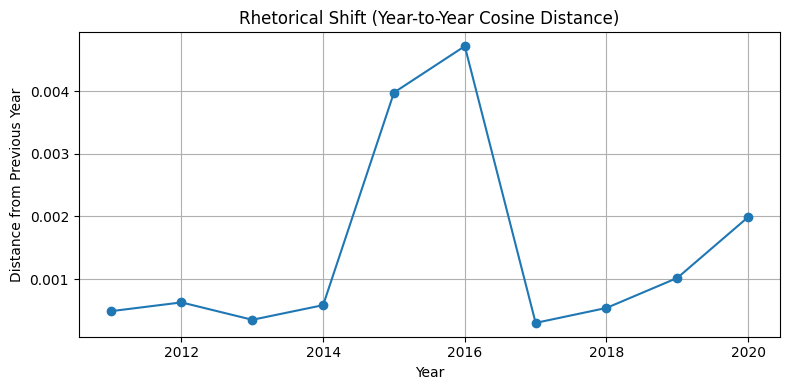

In [46]:
years_yoy = yoy_df["year"].values
vals_yoy = yoy_df["yoy_distance"].values

plt.figure(figsize=(8,4))
plt.plot(years_yoy, vals_yoy, marker="o")
plt.title("Rhetorical Shift (Year-to-Year Cosine Distance)")
plt.xlabel("Year")
plt.ylabel("Distance from Previous Year")
plt.grid(True)
plt.tight_layout()
plt.savefig("embeddings/plot_yoy_distance.png", dpi=200)
plt.show()

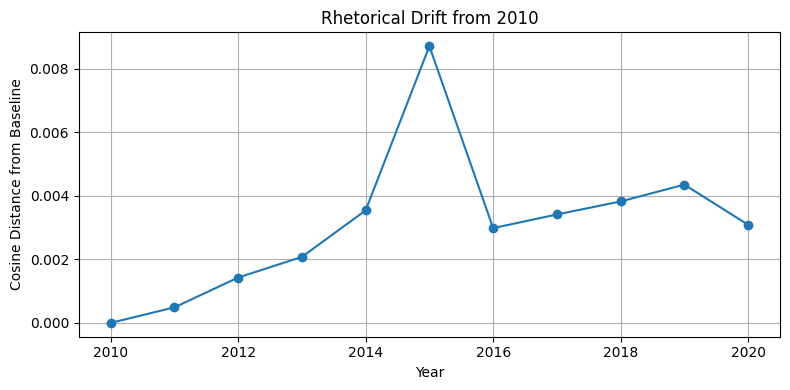

In [47]:
years_drift = drift_df["year"].values
vals_drift = drift_df["drift_distance"].values

plt.figure(figsize=(8,4))
plt.plot(years_drift, vals_drift, marker="o")
plt.title(f"Rhetorical Drift from {baseline_year}")
plt.xlabel("Year")
plt.ylabel("Cosine Distance from Baseline")
plt.grid(True)
plt.tight_layout()
plt.savefig("embeddings/plot_drift_from_baseline.png", dpi=200)
plt.show()

## 📊 Visualizations

In [2]:
import plotly.express as px
import plotly.graph_objects as go

In [3]:
colors = px.colors.qualitative.Prism

In [23]:
prism = px.colors.qualitative.Prism

### RQ1: How do government and opposition parties differ in their emotional rhetoric during political crises?

In [7]:
rq1_rdf = pd.read_csv('RQ1_results_df.csv')

In [8]:
rq1_rdf = rq1_rdf.drop(columns=['Unnamed: 0'])

In [9]:
rq1_rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341805 entries, 0 to 341804
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   member_name      341805 non-null  object 
 1   political_party  341805 non-null  object 
 2   year             341805 non-null  int64  
 3   is_government    341805 non-null  int64  
 4   roles            341805 non-null  object 
 5   anger            341805 non-null  float64
 6   disgust          341805 non-null  float64
 7   fear             341805 non-null  float64
 8   happiness        341805 non-null  float64
 9   sadness          341805 non-null  float64
 10  surprise         341805 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 28.7+ MB


In [10]:
label_map = {1: "Government", 0: "Opposition"}
rq1_rdf["gov_label"] = rq1_rdf["is_government"].map(label_map)

In [11]:
emotions = ["anger", "disgust", "fear", "happiness", "sadness", "surprise"]

In [12]:
means = (
    rq1_rdf.groupby("gov_label")[emotions]
      .mean()
      .reset_index()
      .melt(id_vars="gov_label", var_name="emotion", value_name="mean_score")
)

sems = (
    rq1_rdf.groupby("gov_label")[emotions]
      .agg(lambda x: x.std(ddof=1) / np.sqrt(x.count()))
      .reset_index()
      .melt(id_vars="gov_label", var_name="emotion", value_name="sem")
)

plot_df = means.merge(sems, on=["gov_label", "emotion"])

In [13]:
plot_df["emotion"] = pd.Categorical(plot_df["emotion"], categories=emotions, ordered=True)


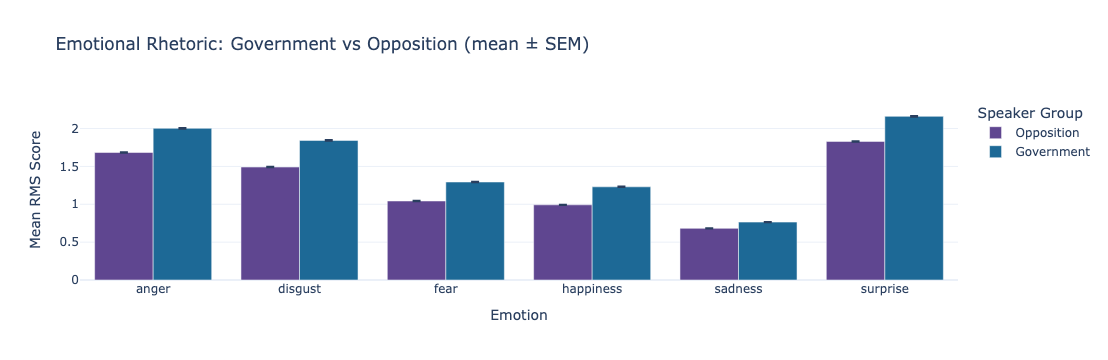

In [15]:
fig = px.bar(
    plot_df,
    x="emotion",
    y="mean_score",
    color="gov_label",
    barmode="group",
    error_y="sem",
    color_discrete_sequence=px.colors.qualitative.Prism,
    category_orders={"gov_label": plot_df["gov_label"].unique()[::-1]},  # reversed order
    labels={
        "emotion": "Emotion",
        "mean_score": "Mean RMS Score",
        "gov_label": "Group"
    },
    title="Emotional Rhetoric: Government vs Opposition (mean ± SEM)"
)

fig.update_layout(
    legend_title_text="Speaker Group",
    bargap=0.20,
    template="plotly_white",
)

# Optional: tidy y-range a bit
ymax = plot_df["mean_score"].max()
fig.update_yaxes(range=[0, ymax * 1.1])

fig.show()

In [17]:
long_df = rq1_rdf.melt(
    id_vars=["year", "gov_label"],
    value_vars=emotions,
    var_name="emotion",
    value_name="score"
)

In [18]:
agg = (
    long_df
    .groupby(["year", "gov_label", "emotion"], as_index=False)
    .agg(
        mean_score=("score", "mean"),
        sem=("score", lambda x: x.std(ddof=1) / np.sqrt(x.count()))
    )
)

In [19]:
agg["emotion"] = pd.Categorical(agg["emotion"], categories=emotions, ordered=True)

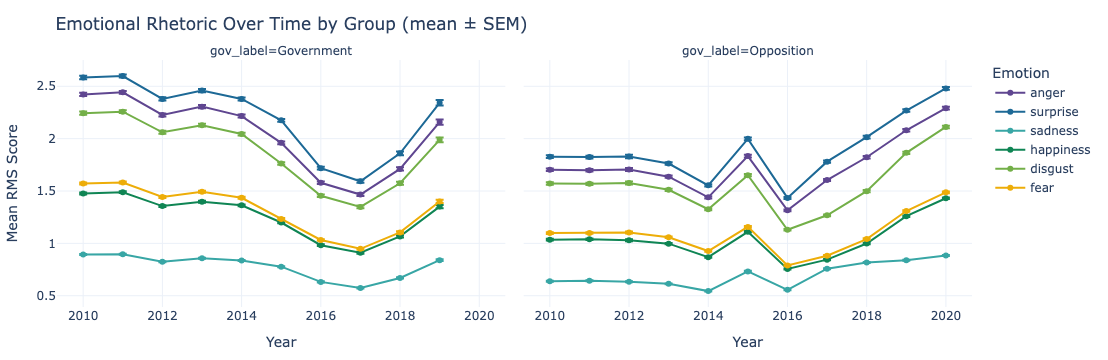

In [20]:
fig = px.line(
    agg.sort_values("year"),
    x="year",
    y="mean_score",
    color="emotion",
    line_group="emotion",
    facet_col="gov_label",
    facet_col_wrap=2,
    markers=True,
    error_y="sem",
    color_discrete_sequence=px.colors.qualitative.Prism,
    labels={
        "year": "Year",
        "mean_score": "Mean RMS Score",
        "emotion": "Emotion"
    },
    title="Emotional Rhetoric Over Time by Group (mean ± SEM)"
)

fig.update_layout(
    template="plotly_white",
    legend_title_text="Emotion",
    margin=dict(l=40, r=20, t=60, b=40),
)

# Make x-axes show integer ticks and share Y across facets
for ax in fig.layout:
    if isinstance(fig.layout[ax], dict) and ax.startswith("xaxis"):
        fig.layout[ax].tickmode = "linear"

fig.update_yaxes(matches="y")  # same y-scale across facets
fig.show()

In [21]:
mean_profiles = (
    rq1_rdf.groupby("gov_label")[emotions]
      .mean()
      .reindex(["Government", "Opposition"])
)

r_gov = mean_profiles.loc["Government", emotions].tolist()
r_opp = mean_profiles.loc["Opposition", emotions].tolist()

# consistent radial range
rmax = max(r_gov + r_opp) * 1.1

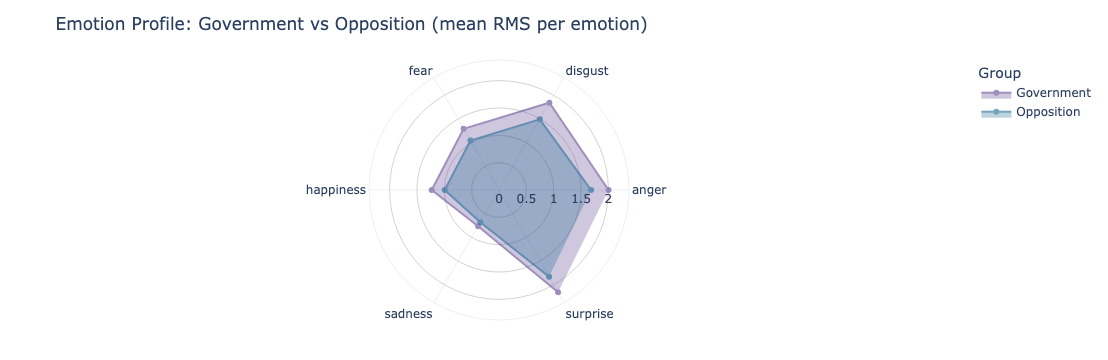

In [24]:
fig = go.Figure()
fig.add_trace(go.Scatterpolar(
    r=r_gov,
    theta=emotions,
    name="Government",
    fill="toself",
    line=dict(width=2, color=prism[0]),
    opacity=0.6
))
fig.add_trace(go.Scatterpolar(
    r=r_opp,
    theta=emotions,
    name="Opposition",
    fill="toself",
    line=dict(width=2, color=prism[1]),
    opacity=0.6
))

fig.update_layout(
    title="Emotion Profile: Government vs Opposition (mean RMS per emotion)",
    polar=dict(
        radialaxis=dict(visible=True, range=[0, rmax], showline=False, gridcolor="lightgray")
    ),
    template="plotly_white",
    legend_title_text="Group",
    margin=dict(l=40, r=20, t=60, b=40)
)

fig.show()

In [20]:
import plotly.subplots as sp 

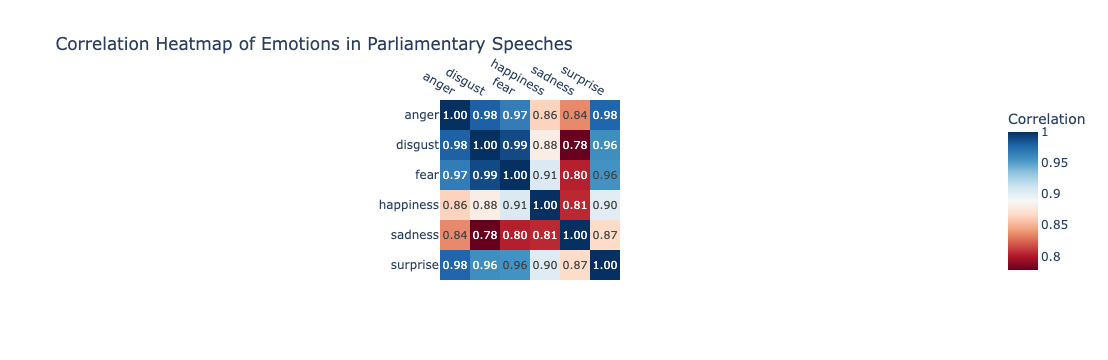

In [23]:
corr_matrix = rq1_rdf[emotions].corr()

# Plotly heatmap
fig = px.imshow(
    corr_matrix,
    x=emotions,
    y=emotions,
    color_continuous_scale=px.colors.diverging.RdBu,
    text_auto=".2f",  # show correlation values
    title="Correlation Heatmap of Emotions in Parliamentary Speeches"
)

fig.update_layout(
    template="plotly_white",
    coloraxis_colorbar=dict(title="Correlation"),
    xaxis_side="top"
)

fig.show()

### RQ2: Do political elites (Prime Minister and Ministers) use more complex or simplified language compared to other MPs?

In [36]:
rq2_rdf = pd.read_csv('RQ2_results_df.csv')

In [41]:
rq2_rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341805 entries, 0 to 341804
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   member_name       341805 non-null  object 
 1   year              341805 non-null  int64  
 2   political_party   341805 non-null  object 
 3   is_government     341805 non-null  int64  
 4   speaker_gov_role  60473 non-null   object 
 5   leadership_role   10689 non-null   object 
 6   roles             341805 non-null  object 
 7   smog_score        8347 non-null    float64
dtypes: float64(1), int64(2), object(5)
memory usage: 20.9+ MB


In [104]:
# 1. Drop null SMOG scores
valid_smog = rq2_rdf[rq2_rdf['smog_score'].notna()]

# 2. Group by speaker and compute average SMOG score
speaker_avg_smog = valid_smog.groupby(
    ['member_name', 'political_party']
)['smog_score'].mean().reset_index()

# 3. Sort and get top 5 and bottom 5
top5 = speaker_avg_smog.sort_values(by='smog_score', ascending=False).head(5)
bottom5 = speaker_avg_smog.sort_values(by='smog_score', ascending=True).head(5)

# 4. Combine results
extremes = pd.concat([top5, bottom5]).reset_index(drop=True)

In [105]:
extremes

,member_name,political_party,smog_score
0,ζαννας γρηγοριου ζησης,συνασπισμος ριζοσπαστικης αριστερας,31.490000
1,βουγιας αλεξανδρου σπυριδων,πανελληνιο σοσιαλιστικο κινημα,29.690000
2,μαρινα χρυσοβελωνη,εξωκοινοβουλευτικός,25.820000
3,ζερδελης χριστοφορου ιωαννης,συνασπισμος ριζοσπαστικης αριστερας,25.130000
4,τζακρη εμμανουηλ θεοδωρα,πανελληνιο σοσιαλιστικο κινημα,25.127500
5,πολυδωρας γεωργιου βυρων,νεα δημοκρατια,14.140000
6,γαλεος αθανασιου γεωργιος,λαικος συνδεσμος - χρυση αυγη,14.170000
7,παπαδοπουλος αβρααμ νικολαος,συνασπισμος ριζοσπαστικης αριστερας,14.215000
8,ιωαννης μουζαλας,εξωκοινοβουλευτικός,14.601176
9,παπαχριστοπουλος θεμιστοκλη αθανασιος (θανασης),συνασπισμος ριζοσπαστικης αριστερας,14.633333


In [100]:
speaker_avg

,year,member_name,speaker_gov_role,smog_score
0,2020,βαρβιτσιωτης ιωαννη μιλτιαδης,αναπληρωτης υπουργος,22.750000
1,2020,βασιλειος κοντοζαμανης,υπουργος,20.010000
2,2020,βεσυροπουλος φωτιου αποστολος,υπουργος,23.095000
3,2020,βοριδης χρηστου μαυρουδης (μακης),υπουργος,16.628571
4,2020,βρουτσης βασιλειου ιωαννης,υπουργος,17.889091
5,2020,γεραπετριτης βασιλειου γεωργιος,υπουργος,19.590000
6,2020,γερασιμος θωμας,υπουργος,20.880000
7,2020,γεωργιαδης αθανασιου σπυριδων-αδωνις,υπουργος,17.253333
8,2020,γεωργιος ζαββος,υπουργος,21.950000
9,2020,γρηγοριος ζαριφοπουλος,υπουργος,19.830000


In [61]:
rq2_rdf.groupby(['year', 'is_government'])['smog_score'] \
       .mean() \
       .reset_index()

,year,is_government,smog_score
0,2010,0,18.329461
1,2010,1,19.487138
2,2011,0,18.536535
3,2011,1,18.865219
4,2012,0,18.797068
5,2012,1,18.782225
6,2013,0,18.854533
7,2013,1,19.167730
8,2014,0,19.245784
9,2014,1,19.193717


In [93]:
rq2_rdf.groupby(['year', 'is_government'])['smog_score'].describe()

count       mean       std    min      25%     50%  \
year is_government                                                       
2010 0              705.0  18.329461  2.254762  12.72  16.7300  18.080   
     1              311.0  19.487138  2.506088  12.94  17.8400  19.080   
2011 0              681.0  18.536535  2.319182  12.16  16.8100  18.320   
     1              389.0  18.865219  2.317293  12.04  17.2200  18.390   
2012 0              266.0  18.797068  2.350045  12.72  17.1850  18.610   
     1              346.0  18.782225  2.316024  13.69  17.0200  18.610   
2013 0              578.0  18.854533  2.284639  12.60  17.1600  18.760   
     1              326.0  19.167730  2.398271  14.14  17.2800  18.980   
2014 0              529.0  19.245784  2.263106  12.75  17.6800  19.080   
     1              269.0  19.193717  2.426604  13.27  17.4300  18.720   
2015 0              419.0  18.315823  2.377250  12.04  16.6200  18.300   
     1              166.0  19.374036  2.721144  13.61  17.3450  19.210   
2016 0              559.0  18.671843  2.300151  13.02  17.1000  18.620   
     1              200.0  18.501300  2.562217  12.19  16.7400  18.350   
2017 0              468.0  19.040000  2.408344  13.00  17.3300  18.840   
     1              216.0  18.316065  2.457265  12.89  16.4375  18.260   
2018 0              439.0  19.024169  2.291044  13.08  17.4100  18.880   
     1              194.0  18.301907  2.572533  13.61  16.2850  18.215   
2019 0              607.0  18.977084  2.891600  12.80  16.8400  18.950   
     1               89.0  19.307191  2.601382  13.40  17.5200  19.020   
2020 0              590.0  18.386881  2.927457  12.28  16.2450  18.170   

                        75%    max  
year is_government                  
2010 0              19.8300  27.41  
     1              21.1400  29.69  
2011 0              20.0300  26.59  
     1              20.2000  26.23  
2012 0              20.2500  26.71  
     1              20.3075  25.47  
2013 0              20.3475  25.63  
     1              20.7700  27.83  
2014 0              20.6900  26.23  
     1              20.9500  26.22  
2015 0              20.0350  29.72  
     1              21.0850  31.49  
2016 0              20.2750  25.68  
     1              20.1750  25.97  
2017 0              20.6650  25.82  
     1              20.0250  24.83  
2018 0              20.4550  26.79  
     1              19.9075  26.18  
2019 0              21.0200  28.16  
     1              21.3300  24.35  
2020 0              20.4300  26.69

In [64]:
yearly_avg_smog = rq2_rdf[rq2_rdf['smog_score'].notna()] \
    .groupby(['year', 'is_government'])['smog_score'] \
    .mean() \
    .reset_index()

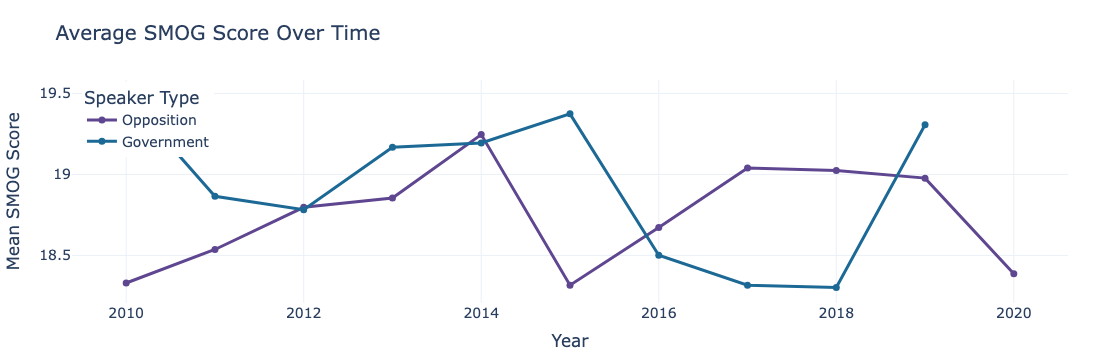

In [77]:
fig = go.Figure()

for i, (label, group) in enumerate(yearly_avg_smog.groupby('is_government')):
    name = 'Government' if label == 1 else 'Opposition'
    fig.add_trace(go.Scatter(
        x=group['year'],
        y=group['smog_score'],
        mode='lines+markers',
        name=name,
        line=dict(width=3, color=colors[i]),
        marker=dict(size=7, color=colors[i])
    ))

# Layout styling with Plotly + Prisma aesthetic
fig.update_layout(
    title="Average SMOG Score Over Time",
    xaxis_title="Year",
    yaxis_title="Mean SMOG Score",
    template="plotly_white",
    legend=dict(title="Speaker Type", x=0.01, y=0.99),
    hovermode="x unified",
    font=dict(size=14),
    margin=dict(l=40, r=40, t=80, b=40)
)

fig.show()

In [68]:
speech_counts = rq2_rdf[rq2_rdf['smog_score'].notna()] \
    .groupby(['year', 'is_government'])['smog_score'] \
    .count() \
    .reset_index() \
    .rename(columns={'smog_score': 'speech_count'})

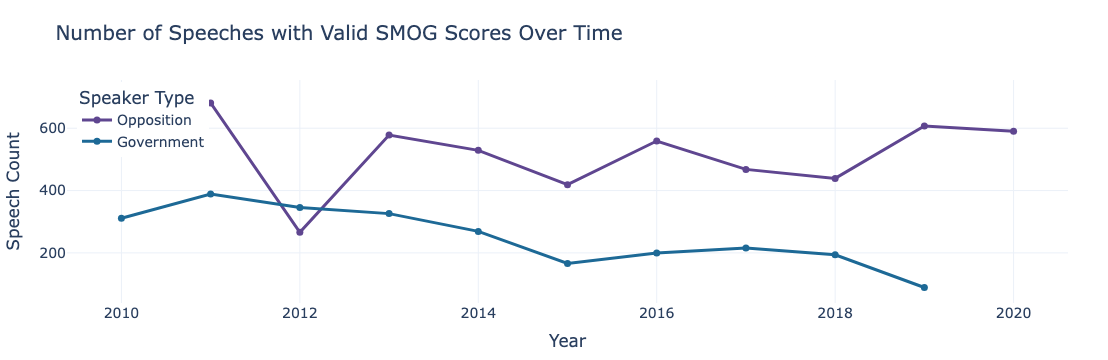

In [79]:
# Build interactive line chart for speech count
fig = go.Figure()

for i, (label, group) in enumerate(speech_counts.groupby('is_government')):
    name = 'Government' if label == 1 else 'Opposition'
    fig.add_trace(go.Scatter(
        x=group['year'],
        y=group['speech_count'],
        mode='lines+markers',
        name=name,
        line=dict(width=3, color=colors[i]),
        marker=dict(size=7, color=colors[i])
    ))

# Apply layout and Prisma-friendly styling
fig.update_layout(
    title="Number of Speeches with Valid SMOG Scores Over Time",
    xaxis_title="Year",
    yaxis_title="Speech Count",
    template="plotly_white",
    legend=dict(title="Speaker Type", x=0.01, y=0.99),
    hovermode="x unified",
    font=dict(size=14),
    margin=dict(l=40, r=40, t=80, b=40)
)

fig.show()

In [53]:
valid_smog = rq2_rdf[rq2_rdf['smog_score'].notna()]

In [82]:
from plotly.subplots import make_subplots

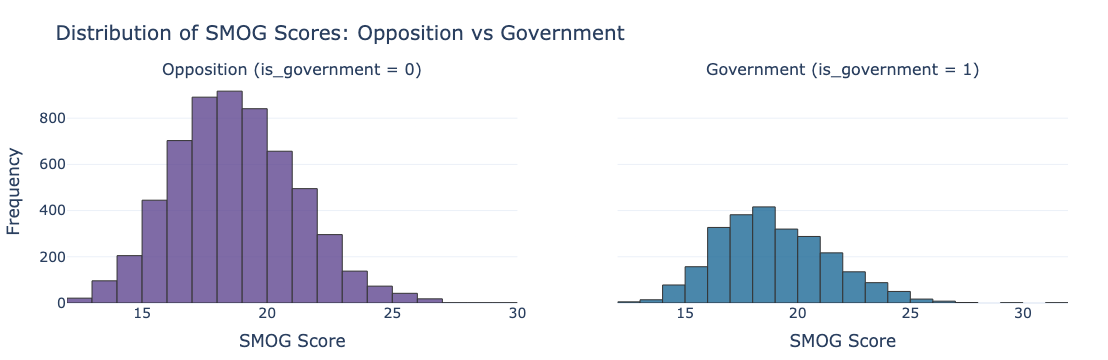

In [85]:
# Filter valid scores
valid_smog = rq2_rdf[rq2_rdf['smog_score'].notna()]
gov_scores = valid_smog[valid_smog['is_government'] == 1]['smog_score']
opp_scores = valid_smog[valid_smog['is_government'] == 0]['smog_score']

# Create side-by-side subplot layout
fig = make_subplots(
    rows=1, cols=2,
    shared_yaxes=True,
    subplot_titles=("Opposition (is_government = 0)", "Government (is_government = 1)")
)

# Add Opposition histogram
fig.add_trace(go.Histogram(
    x=opp_scores,
    nbinsx=30,
    name='Opposition',
    marker=dict(color=colors[0], line=dict(width=1, color='black')),
    opacity=0.8,
    showlegend=False
), row=1, col=1)

# Add Government histogram
fig.add_trace(go.Histogram(
    x=gov_scores,
    nbinsx=30,
    name='Government',
    marker=dict(color=colors[1], line=dict(width=1, color='black')),
    opacity=0.8,
    showlegend=False
), row=1, col=2)

# Update layout
fig.update_layout(
    title="Distribution of SMOG Scores: Opposition vs Government",
    template="plotly_white",
    font=dict(size=14),
    margin=dict(l=40, r=40, t=80, b=40),
    xaxis_title="SMOG Score",
    xaxis2_title="SMOG Score",
    yaxis_title="Frequency"
)

fig.show()

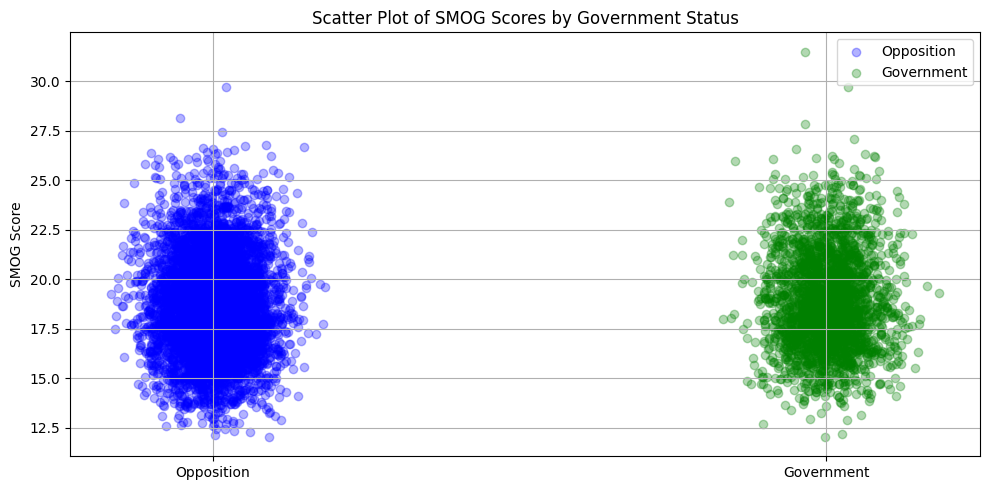

In [89]:
# 1. Filter out speeches with valid SMOG scores
valid_smog = rq2_rdf[rq2_rdf['smog_score'].notna()]

# 2. Split into government and opposition
gov_scores = valid_smog[valid_smog['is_government'] == 1]['smog_score']
opp_scores = valid_smog[valid_smog['is_government'] == 0]['smog_score']

# 3. Add slight jitter on the x-axis to prevent overlap
x_opp = [0 + 0.05 * np.random.randn() for _ in range(len(opp_scores))]
x_gov = [1 + 0.05 * np.random.randn() for _ in range(len(gov_scores))]

# 4. Create the scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(x_opp, opp_scores, alpha=0.3, label='Opposition', color='blue')
plt.scatter(x_gov, gov_scores, alpha=0.3, label='Government', color='green')

# 5. Format the plot
plt.xticks([0, 1], ['Opposition', 'Government'])
plt.ylabel("SMOG Score")
plt.title("Scatter Plot of SMOG Scores by Government Status")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
from scipy.stats import ttest_ind

gov_scores = valid_smog[valid_smog['is_government'] == 1]['smog_score']
opp_scores = valid_smog[valid_smog['is_government'] == 0]['smog_score']

t_stat, p_value = ttest_ind(gov_scores, opp_scores, equal_var=False)  # Welch’s t-test

print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")

T-statistic: 3.572, p-value: 0.0004


In [56]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(gov_scores, opp_scores, alternative='two-sided')

print(f"U-statistic: {u_stat:.3f}, p-value: {p_value:.4f}")

U-statistic: 7600343.500, p-value: 0.0053


In [107]:
from numpy import mean, std
from math import sqrt

d = (mean(gov_scores) - mean(opp_scores)) / sqrt((std(gov_scores)**2 + std(opp_scores)**2) / 2)
print("Cohen's d:", round(d, 3))

Cohen's d: 0.085


### RQ3: Has the government’s rhetorical style shifted over time? (Greek BERT)

In [17]:
# Read the pairwise cosine distance matrix
dist_df = pd.read_csv("embeddings/year_pairwise_cosine_distance.csv", index_col=0)

# Read the year-over-year distances
yoy_df = pd.read_csv("embeddings/year_yoy_distance.csv")

# Read the drift-from-baseline distances
drift_df = pd.read_csv("embeddings/year_drift_from_baseline.csv")

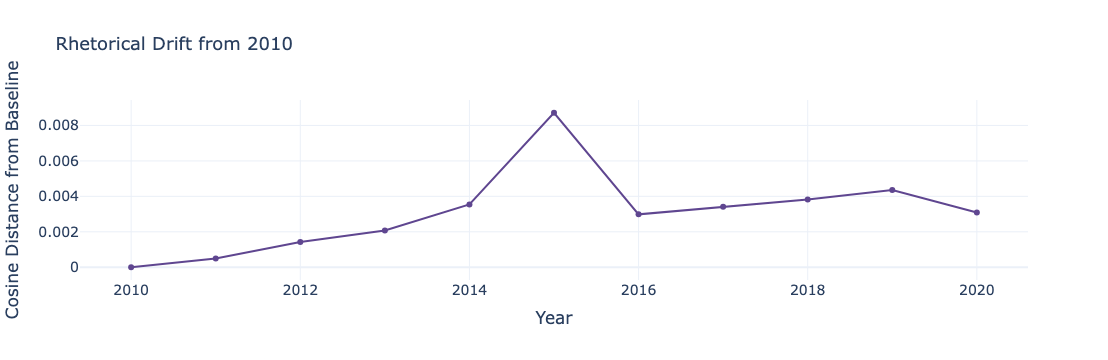

In [22]:
fig_drift = px.line(
    drift_df, 
    x="year", 
    y="drift_distance", 
    markers=True, 
    title=f"Rhetorical Drift from {drift_df['from_year'].iloc[0]}",
    color_discrete_sequence=colors
)

fig_drift.update_layout(
    template="plotly_white",
    xaxis_title="Year",
    yaxis_title="Cosine Distance from Baseline",
    title_font_size=18,
    font=dict(size=14),
    plot_bgcolor="white"
)

fig_drift.show()

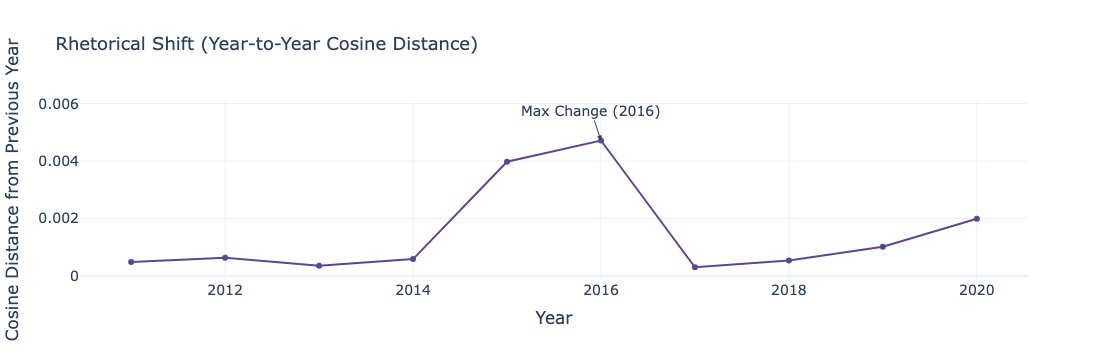

In [23]:
# Create figure
fig_yoy = px.line(
    yoy_df, 
    x="year", 
    y="yoy_distance", 
    markers=True, 
    title="Rhetorical Shift (Year-to-Year Cosine Distance)",
    color_discrete_sequence=colors
)

# Find max change year/value
max_year = yoy_df.loc[yoy_df["yoy_distance"].idxmax(), "year"]
max_val = yoy_df["yoy_distance"].max()

# Add annotation
fig_yoy.add_annotation(
    x=max_year,
    y=max_val,
    text=f"Max Change ({max_year})",
    showarrow=True,
    arrowhead=2
)

# Layout polish
fig_yoy.update_layout(
    template="plotly_white",
    xaxis_title="Year",
    yaxis_title="Cosine Distance from Previous Year",
    title_font_size=18,
    font=dict(size=14),
    plot_bgcolor="white"
)

fig_yoy.show()